In [1]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import os
from numpy import median 
import seaborn as sns
import pandas as pd
import scipy.stats as stats
from scipy import signal 
from scipy.ndimage import gaussian_filter1d
from scipy import interpolate
import cPickle as pickle
from lab.classes.dbclasses import dbMouse
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison
from itertools import groupby
from operator import itemgetter

In [2]:
%run Helper_Functions.ipynb

In [ ]:
mouseList = ['bv119', 'bv125', 'bv132', 'bv135', 'bv136', 'bv138', 'bv140', 'bv142', 'bv143']

allData = []
for mouseID in mouseList:
    print(mouseID), 
    labels = pd.read_excel('/data2/bert/CA3/Histology/Subtypes.xlsx', sheet_name = mouseID)
    
    exptList = [expt for expt in dbMouse(mouseID).imagingExperiments() if \
                expt.belt_id != 'belt_B' and expt.laps >= 10]
    
    for expt in exptList:
        print expt.experimentType, expt.belt_id, expt.laps
        if ('all' or 'all_fissa') in expt.labels(): 
            if expt.hasDfofTracesFile(): 
                subtype_id = ROI_planeID(expt, 'all_fissa') 
                roi_label = 'all_fissa'
                
                filepath = expt.sima_path() + '/place_fields_FISSA.pkl'
                with open(filepath, 'rb') as f:
                    data = pickle.load(f)
                smoothed_tuning_curves = data['spatial_tuning_smooth']
                
                filepath2 = expt.sima_path() + '/shuffled_tuning_curves_FISSA.pkl'
                with open(filepath2, 'rb') as f:
                    shuffles = pickle.load(f)
                fp = shuffles['Five_Perc_Tuning_Curves']
                
                for roiID in xrange(fp.shape[0]): 
                    crossings = np.where(smoothed_tuning_curves[roiID] < fp[roiID])[0]
                    place_IN_status = False
                    intervals = []
                    if len(crossings) < 10:
                        place_IN_status = False
                    else:
                        for k, g in groupby(enumerate(crossings), lambda (i,x): i-x):
                            intervals.append(map(itemgetter(1), g))
                        if len(intervals) > 1:
                            if intervals[0][0] == 0 and intervals[-1][-1] == 99:
                                intervals[0] = intervals[-1] + intervals[0]
                                del intervals[-1]
                        for interval in intervals:
                            if len(interval) >= 10:
                                place_IN_status = True
                                break
                    
                    
                    allData.append({'Mouse': mouseID, 'expt': expt.trial_id, 
                                    'Day': expt.day,
                                    'Session': expt.session,
                                    'Negative_Place_IN': place_IN_status,
                                    'Subtype': labels['Subtype'][subtype_id[roiID]], 
                                    'Layer': labels['Layer'][subtype_id[roiID]],  
                                    'Region': labels['Region'][subtype_id[roiID]],
                                    'Imaging_Plane': subtype_id[roiID], 
                                    'SATB1': labels['SATB1'][subtype_id[roiID]]})

allData = pd.DataFrame(allData)
allData = allData[allData.Region != 'CA1']

In [4]:
to_drop = allData.loc[(allData.Subtype == 'CB') & (allData.SATB1  == '-')].index
allData = allData.drop(index = to_drop)

In [ ]:
fraction_tuned_INs_per_expt = []
for expt in np.unique(allData.expt):
    fraction_tuned_INs_per_expt.append({'expt': expt, \
        'Mouse': allData[allData.expt == expt].Mouse.iloc[0], \
        'Fraction_Tuned': len(allData[allData.expt == expt][allData.Negative_Place_IN == True])/ \
            float(len(allData[allData.expt == expt]))})
fraction_tuned_INs_per_expt = pd.DataFrame(fraction_tuned_INs_per_expt)

In [9]:
CA3_data = allData[allData.Region == 'CA3']

In [ ]:
subtype_fraction_tuned_per_expt = []
subtypes = ['PVBC', 'AAC', 'SOM', 'CCK', 'CB']
for expt in np.unique(CA3_data.expt):
    for subtype in subtypes:
        if len(CA3_data[CA3_data.Subtype == subtype][CA3_data.expt == expt]) > 1:
            subtype_fraction_tuned_per_expt.append({'expt': expt, \
                'Subtype': subtype, \
                'Mouse': CA3_data[CA3_data.expt == expt].Mouse.iloc[0],
                'Fraction_Tuned': len(CA3_data[CA3_data.expt == expt][CA3_data.Subtype == subtype] \
                    [CA3_data.Negative_Place_IN == True])/ \
                    float(len(CA3_data[CA3_data.expt == expt][CA3_data.Subtype == subtype]))})
subtype_fraction_tuned_per_expt = pd.DataFrame(subtype_fraction_tuned_per_expt)

In [ ]:
region_fraction_tuned_per_expt = []
regions = ['CA2', 'CA3']
for expt in np.unique(allData.expt):
    for region in regions:
        if len(allData[allData.Region == region][allData.expt == expt]) > 1:
            region_fraction_tuned_per_expt.append({'expt': expt, \
                'Region': region, \
                'Mouse': allData[allData.expt == expt].Mouse.iloc[0],
                'Fraction_Tuned': len(allData[allData.expt == expt][allData.Region == region] \
                    [allData.Negative_Place_IN == True])/ \
                    float(len(allData[allData.expt == expt][allData.Region == region]))})
region_fraction_tuned_per_expt = pd.DataFrame(region_fraction_tuned_per_expt)

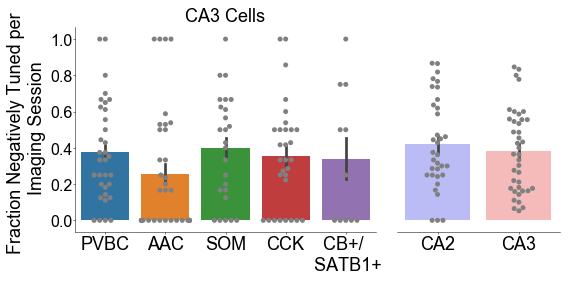

In [12]:
fig = plt.figure(figsize = (8, 4))
gs = gridspec.GridSpec(1, 11, figure = fig)
fig_ax1 = fig.add_subplot(gs[:,0:7])

order = ['PVBC', 'AAC', 'SOM', 'CCK', 'CB']
sns.swarmplot(y = 'Fraction_Tuned', x = 'Subtype', data = subtype_fraction_tuned_per_expt, \
              order = order, color = 'gray', ax = fig_ax1)
sns.barplot(y = 'Fraction_Tuned', x = 'Subtype', data = subtype_fraction_tuned_per_expt, \
            ci = 68, order = order, ax = fig_ax1)
fig_ax1.set_xlabel('')
fig_ax1.tick_params(axis = 'y', labelsize = 16)
fig_ax1.set_xticklabels(['PVBC', 'AAC', 'SOM', 'CCK', 'CB+/ \n SATB1+'], fontsize = 18)
fig_ax1.set_ylabel('Fraction Negatively Tuned per \n Imaging Session', fontsize = 18)
fig_ax1.set_title('CA3 Cells', fontsize = 18)
simpleaxis(fig_ax1)

fig_ax2 = fig.add_subplot(gs[:,7:], sharey = fig_ax1)
order = ['CA2', 'CA3']
mypalette = ['blue', 'red']
sns.swarmplot(x = 'Region', y = 'Fraction_Tuned', data = region_fraction_tuned_per_expt, \
             order = order, color = 'gray', ax = fig_ax2)
sns.barplot(x = 'Region', y = 'Fraction_Tuned', data = region_fraction_tuned_per_expt, \
             order = order, ci = 68, palette = mypalette, alpha = 0.3, ax = fig_ax2)
fig_ax2.set_ylabel('', fontsize = 18)
fig_ax2.tick_params(axis = 'y', labelsize = 16)
fig_ax2.set_xticklabels(['CA2', 'CA3'], fontsize = 18)
fig_ax2.get_yaxis().set_visible(False)
fig_ax2.spines['left'].set_visible(False)
fig_ax2.set_xlabel('')
simpleaxis(fig_ax2)

fig.tight_layout()
plt.savefig('Fraction_Negative_Tuned_by_Subtype_and_Region.svg', format = 'svg', \
            dpi = 1200, transparent = True)